In [1]:
pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = '/content/drive/My Drive/dataset'

In [6]:
import tensorflow as tf

def decode_image(file_path, target_size=(64, 64)):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img

def create_dataset(image_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# all image paths
image_paths = glob.glob(dataset_path + '/**/*.jpg', recursive=True)

#training and test sets
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)


train_dataset = create_dataset(train_paths, batch_size=32)
test_dataset = create_dataset(test_paths, batch_size=32)


In [11]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf

# Network parameters
image_shape = (64, 64, 3)
latent_dim = 2

# Encoder architecture
inputs = Input(shape=image_shape, name='encoder_input')
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(lambda p: p[0] + K.exp(p[1] / 2) * K.random_normal(K.shape(p[0])), output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(16 * 16 * 64, activation='relu')(latent_inputs)
x = Reshape((16, 16, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

#final layer
outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same', name='decoder_output')(x)

# Instantiate decoder
decoder = Model(latent_inputs, outputs, name='decoder')

# Instantiate VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_shape[0] * image_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Summary
vae.summary()



Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  281620    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 64, 64, 3)            105411    ['encoder[0][2]']             
                                                                                            

In [12]:
print(K.int_shape(inputs))
print(K.int_shape(outputs))

(None, 64, 64, 3)
(None, 64, 64, 3)


In [13]:
# Training VAE
vae.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
134/134 [==============================] - 112s 813ms/step - loss: 2755.3733 - val_loss: 2728.8833
Epoch 2/30
134/134 [==============================] - 86s 643ms/step - loss: 2729.8081 - val_loss: 2726.5854
Epoch 3/30
134/134 [==============================] - 83s 614ms/step - loss: 2729.1531 - val_loss: 2726.5547
Epoch 4/30
134/134 [==============================] - 86s 643ms/step - loss: 2728.9724 - val_loss: 2726.0977
Epoch 5/30
134/134 [==============================] - 83s 615ms/step - loss: 2728.6692 - val_loss: 2726.1023
Epoch 6/30
134/134 [==============================] - 82s 610ms/step - loss: 2728.6365 - val_loss: 2726.1816
Epoch 7/30
134/134 [==============================] - 85s 635ms/step - loss: 2728.3149 - val_loss: 2726.2324
Epoch 8/30
134/134 [==============================] - 99s 737ms/step - loss: 2728.3040 - val_loss: 2726.6270
Epoch 9/30
134/134 [==============================] - 93s 692ms/step - loss: 2728.2383 - val_loss: 2726.2388
Epoch 10/30
134/13

1/1 [==============================] - 0s 43ms/step


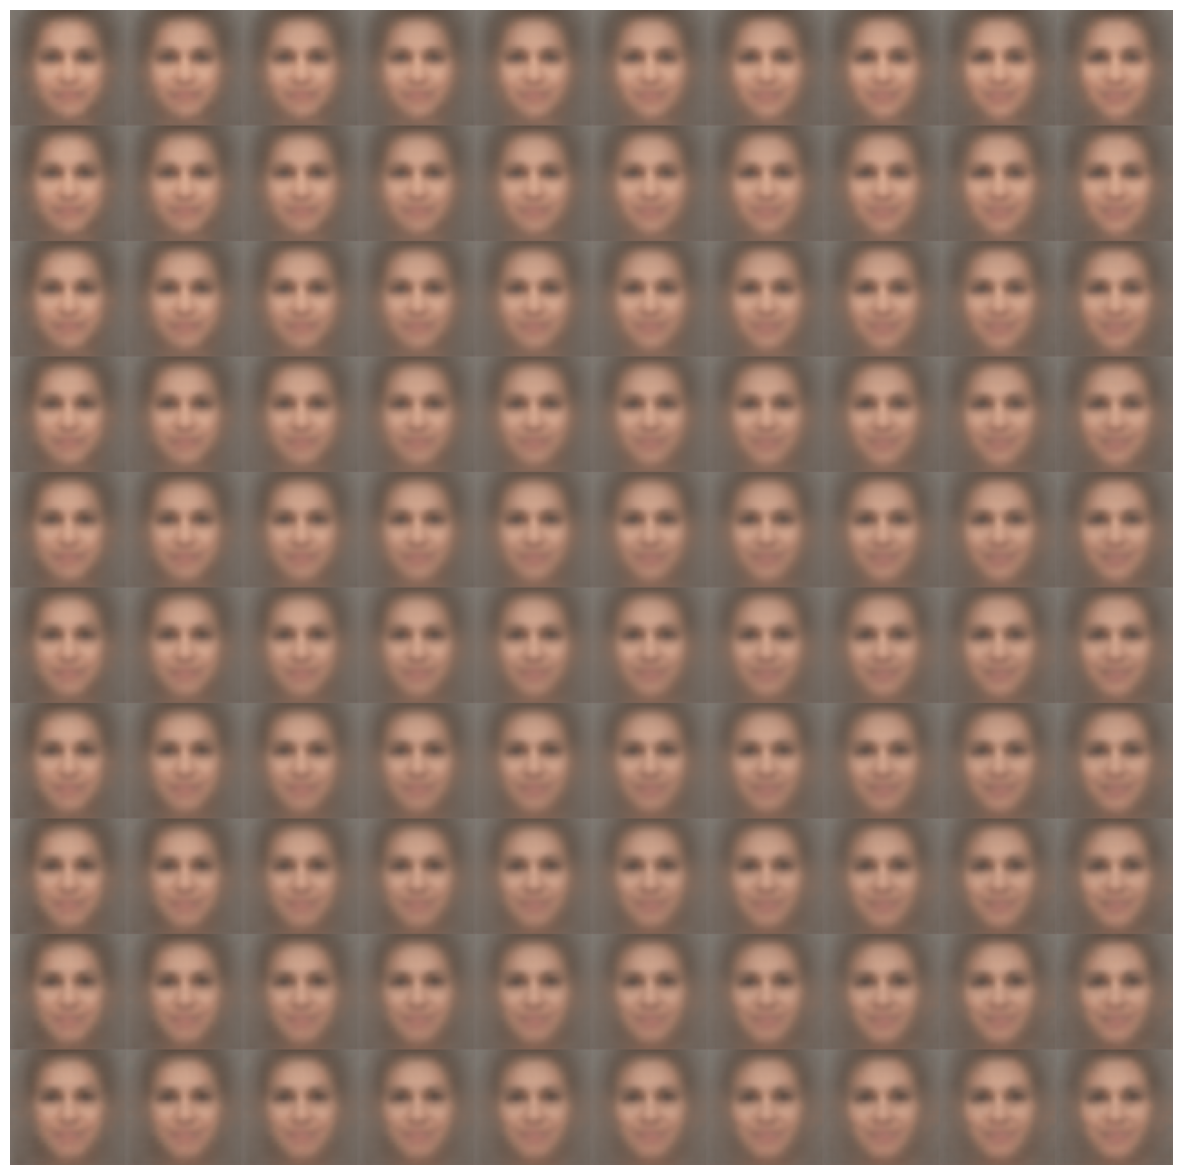

In [15]:
import matplotlib.pyplot as plt
def plot_latent_space(decoder, n=10, figsize=15):
    # Display a grid
    digit_size = 64
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            face = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = face
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, aspect='auto')
    plt.axis('off')
    plt.show()

plot_latent_space(decoder)


1/1 [==============================] - 0s 138ms/step


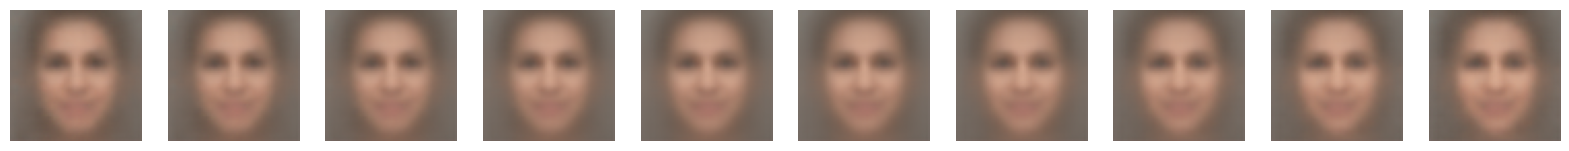

In [17]:
def interpolate_between_two_points(decoder, start_point, end_point, n=10):
    start_point = start_point.flatten()
    end_point = end_point.flatten()


    z_samples = np.linspace(start_point, end_point, n)

    # Prediction using the decoder
    images = decoder.predict(z_samples)

    plt.figure(figsize=(20, 4))
    for i, image in enumerate(images):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(image.reshape(64, 64, 3))
        plt.axis('off')
    plt.show()
start_point = np.array([[-3, -3]])
end_point = np.array([[3, 3]])

interpolate_between_two_points(decoder, start_point, end_point)


In [21]:
encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')
vae.save('vae_full_model.h5')

In [22]:
vae.save_weights('vae_original_weights.h5')

In [23]:
beta = 0.01
# Computing VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_shape[0] * image_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 * beta
vae_loss = K.mean(reconstruction_loss + kl_loss)

#VAE model with the new loss
vae = Model(inputs, outputs, name='vae_mlp')
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [24]:
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Loss = {logs['loss']}, Validation Loss = {logs['val_loss']}")

# Train
vae.fit(train_dataset, epochs=30, validation_data=test_dataset, callbacks=[LossCallback()])


Epoch 1/30
134/134 [==============================] - 124s 630ms/step - loss: 2727.8342 - val_loss: 2725.9460
Epoch 2/30
134/134 [==============================] - 82s 611ms/step - loss: 2727.5583 - val_loss: 2726.0811
Epoch 3/30
134/134 [==============================] - 96s 717ms/step - loss: 2727.5391 - val_loss: 2725.7898
Epoch 4/30
134/134 [==============================] - 95s 708ms/step - loss: 2727.5239 - val_loss: 2725.9346
Epoch 5/30
134/134 [==============================] - 82s 611ms/step - loss: 2727.3845 - val_loss: 2725.8267
Epoch 6/30
134/134 [==============================] - 82s 609ms/step - loss: 2727.5393 - val_loss: 2725.8254
Epoch 7/30
134/134 [==============================] - 94s 699ms/step - loss: 2727.4817 - val_loss: 2725.8035
Epoch 8/30
134/134 [==============================] - 93s 694ms/step - loss: 2727.4561 - val_loss: 2725.7852
Epoch 9/30
134/134 [==============================] - 81s 600ms/step - loss: 2727.4207 - val_loss: 2725.8462
Epoch 10/30
134/13

Epoch 1/2
1/1 [==============================] - 0s 106ms/step


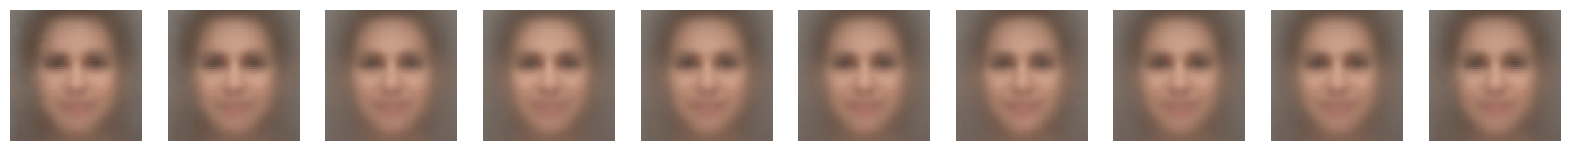

134/134 [==============================] - 133s 995ms/step - loss: 2727.1035 - val_loss: 2725.5134
Epoch 2/2
1/1 [==============================] - 0s 49ms/step


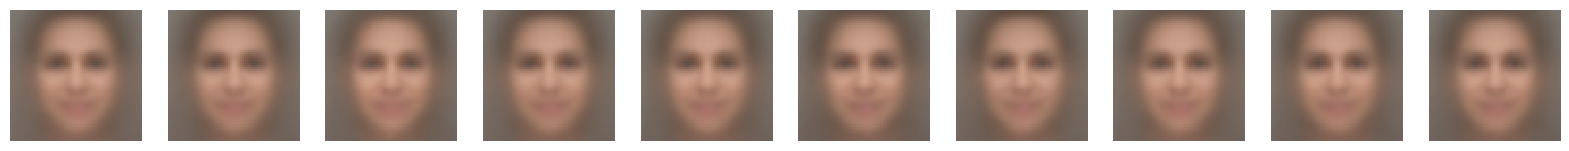

134/134 [==============================] - 104s 776ms/step - loss: 2727.1118 - val_loss: 2725.2507


In [28]:
def generate_and_plot_images(decoder, epoch, latent_dim):
    # Generate images
    z_new = np.random.normal(size=(10, latent_dim))
    images = decoder.predict(z_new)

    # Plot images
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, :], interpolation='nearest')
        ax.axis('off')
    plt.show()

#generate and plot images after each epoch
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim):
        self.decoder = decoder
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        generate_and_plot_images(self.decoder, epoch, self.latent_dim)

# Instantiate
generate_images_callback = GenerateImagesCallback(decoder, latent_dim)

# Train with the new callback
vae.fit(train_dataset, epochs=2, validation_data=test_dataset, callbacks=[LossCallback(), generate_images_callback])



In [30]:
encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')
vae.save('vae_full_model.h5')